In [15]:
import os 
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import numpy as np
import keras.layers as KL
import keras.models as KM
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.layers import BatchNormalization,ZeroPadding2D,AveragePooling2D
from keras.optimizers import SGD
from keras import backend as K
import cv2
import glob
import matplotlib.pyplot as plt

# Read Image List

In [2]:
images = [cv2.resize(cv2.imread(file,cv2.IMREAD_GRAYSCALE)/255, (224, 224)).astype('float32')  for file in glob.glob("Train/*")]
images_label = [float(file.split("/")[1].split("_")[0])-1 for file in glob.glob("Train/*")]

<IPython.core.display.Javascript object>


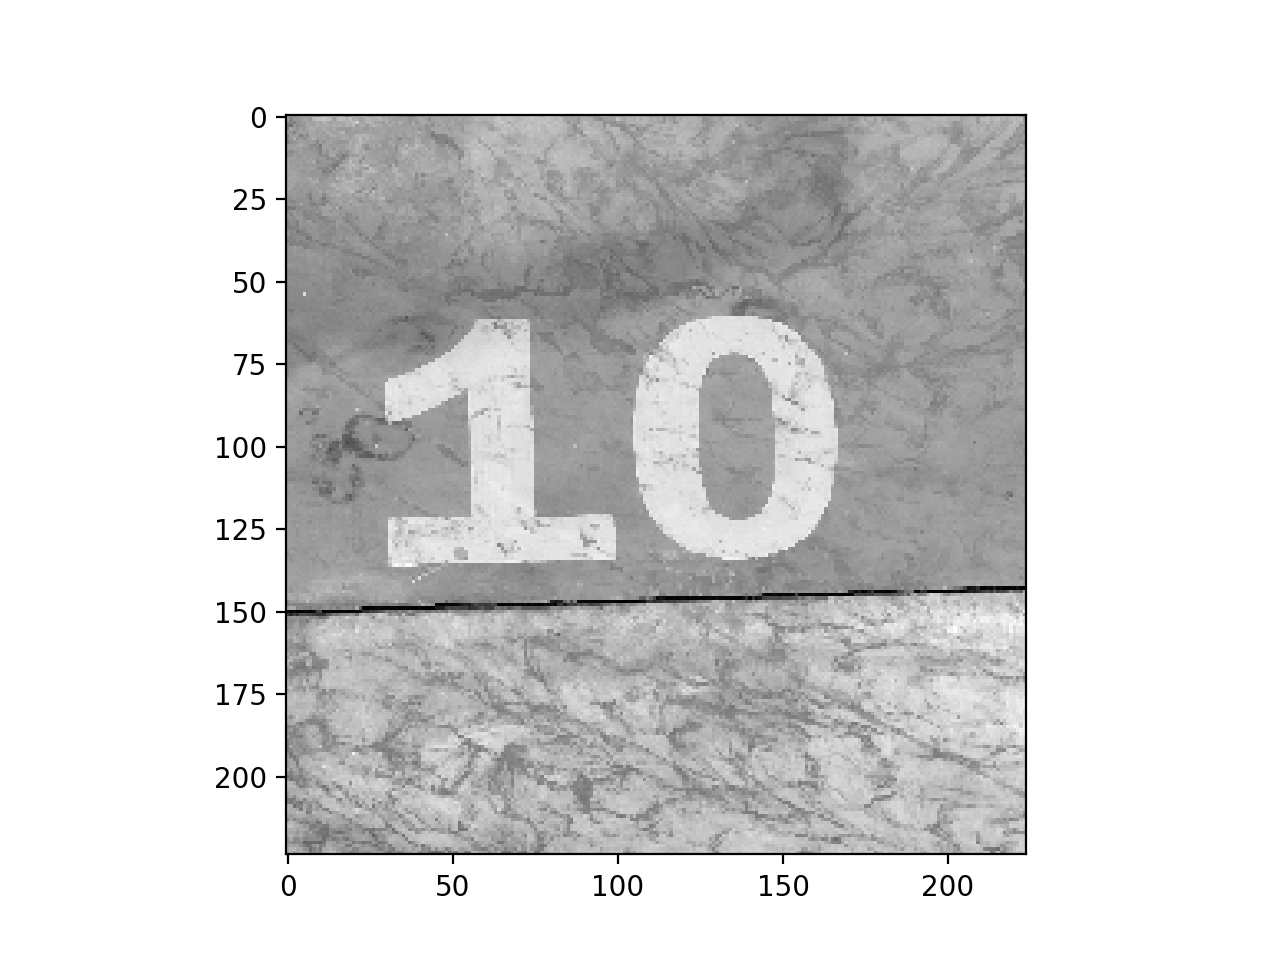

In [3]:
%matplotlib notebook
plt.imshow(images[0], cmap="gray")
plt.show()

# Trainning

In [4]:
batch_size = 128
num_classes = 14
epochs = 1000

# input image dimensions
img_rows, img_cols = 224, 224

x_train = np.array(images)
y_train = np.array(images_label)

# the data, split between train and test sets
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
#     x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
#     x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)



print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=input_shape))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))
# model.summary()
# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.Adadelta(),
#               metrics=['accuracy'])






# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

x_train shape: (47, 224, 224, 1)
47 train samples


In [5]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = KL.Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        strides: Strides for the first conv layer in the block.
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the first conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = KL.Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [9]:
def ResNet50(include_top=False, classes=14):


    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    
    img_input = Input(shape=input_shape)    
    x = ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid', name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    if include_top:
        x = Flatten()(x)
        x = Dense(classes, activation='softmax', name='fc1000')(x)
    


    inputs = img_input
    # Create model.
    model = KM.Model(inputs, x, name='resnet50')
    
    return model

In [10]:
AMASmodel = ResNet50()

In [16]:
sgd  = SGD(lr=0.01,decay=1e-6,momentum=0.9,nesterov=True)

In [17]:
AMASmodel.compile(loss='binary_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [19]:
AMASmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [18]:
AMASmodel.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,)

ValueError: Error when checking target: expected avg_pool to have 4 dimensions, but got array with shape (47, 14)

In [44]:
model.save_weights("AmasModel.h5")

# Test

In [50]:
import random 
num_classes = 14
#load Test image

test_images = [cv2.resize(cv2.imread(file,cv2.IMREAD_GRAYSCALE)/255, (224, 224)).astype('float32')  for file in glob.glob("Test/*")]
test_images_label = [float(file.split("/")[1].split("_")[0])-1 for file in glob.glob("Test/*")]


# input image dimensions
img_rows, img_cols = 224, 224
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)


In [3]:
# build model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.load_weights("AmasModel.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 110, 110, 64)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 774400)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               99123328  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

truth: 7


<IPython.core.display.Javascript object>


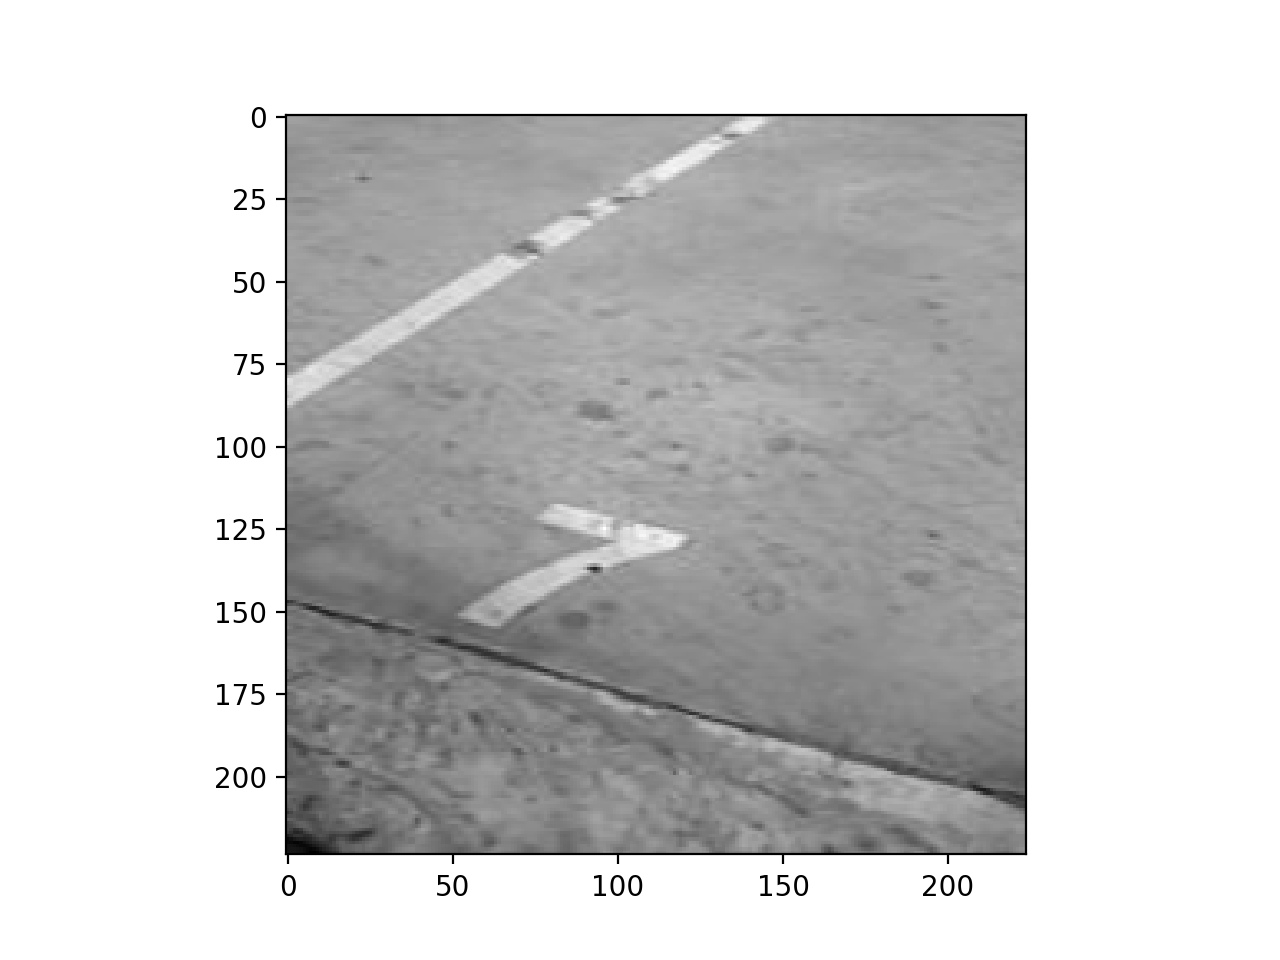

prob: [[4.3210277e-01 2.5945008e-02 2.7079201e-05 5.0745434e-01 2.6476168e-04
  1.6582517e-02 1.2624413e-03 7.1841649e-05 4.0667524e-04 3.0216092e-04
  1.2745737e-02 2.3938771e-03 7.9999336e-06 4.3290085e-04]]
pred: 4


In [43]:
#random choose image
num = random.randint(0,len(test_images))
img = test_images[num]
lab = test_images_label[num]
print("truth: {}".format(int(lab+1)))
%matplotlib notebook
plt.imshow(img, cmap="gray")
plt.show()

n_img = np.expand_dims(img,axis=0)
n_img = np.expand_dims(n_img,axis=-1)
prob = model.predict(n_img)
print("prob: {}".format(prob))
pred = np.argmax(prob) +1
print("pred: {}".format(int(pred)))

In [55]:
images_label

[9.0,
 9.0,
 9.0,
 10.0,
 10.0,
 10.0,
 11.0,
 11.0,
 11.0,
 12.0,
 12.0,
 12.0,
 13.0,
 13.0,
 13.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 5.0,
 5.0,
 5.0,
 5.0,
 6.0,
 6.0,
 6.0,
 7.0,
 7.0,
 7.0,
 8.0,
 8.0,
 8.0]